In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.now()

## First we say what query and project we are interested in

In [2]:
pid = 217
qid = 7966
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

94944


94944

### And we retrieve those documents that have been screened in that query

In [3]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

94944


3000

### We have a separate list of documents in the query that have not been screened

In [4]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(91944, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,4,"In America, entertainment celebrities have ent...","From sidekick to sideshow - Celebrity, enterta...",politics of distraction; celebrity politics; c...,"[Psychology, Clinical; Social Sciences, Interd...",0,0
1,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
2,29,In an stylized endogenous growth economy with ...,Optimal green tax reforms yielding double divi...,Double dividend; Emissions tax; Dynamic Laffer...,[Economics; Energy & Fuels; Environmental Scie...,0,0
3,65,The world's increasing need is to develop smar...,Synthesis of a Cementitious Material Nanocemen...,None,[Nanoscience & Nanotechnology; Materials Scien...,0,0
4,74,Numerous epidemiological studies have demonstr...,Particulate matter in the indoor air of classr...,indoor; schools; classrooms; particulate matte...,[Environmental Sciences; Meteorology & Atmosph...,0,0


### We gather the screening decisions (relevant=1, not relevant=0) and make a dataframe from them

In [5]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(2952, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,778345,Finding the right balance between centralizati...,Ambitious climate policy through centralizatio...,Centralization; climate policy; decentralizati...,[Environmental Studies; Public Administration],1,1
1,785897,This paper analyzes hybrid emissions trading s...,Combining price and quantity controls under pa...,Emission trading; Hybrid regulation; Partition...,[Economics],1,1
2,437137,Based on qualitative research and a case study...,Triggering Community Conservation Through the ...,community conservation; market-based instrumen...,[Development Studies; Environmental Studies; R...,1,1
3,1307625,Mixed coniferous forests are widespread at mid...,Millennial scale climate-fire-vegetation inter...,Fire history; Vegetation history; Mixed-conife...,"[Geography, Physical; Geosciences, Multidiscip...",1,1
4,196766,Article 2 of the United Nations Framework Conv...,"Dangerous anthropogenic interference, dangerou...",None,[Environmental Sciences; Meteorology & Atmosph...,1,1


### And we merge the two, with a column "seen" recording if a document has been seen or not

In [6]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,715896,Rhizospheric methane oxidation was evaluated a...,Evaluation of methane oxidation in the rhizosp...,Carex; methane oxidation; methyl fluoride; pea...,"[Environmental Sciences; Geosciences, Multidis...",0,0
1,573262,Arctic coastal populations share a close relat...,The human dimensions of marine mammal manageme...,Marine mammals; Human dimensions; Policy; Clim...,[Environmental Studies; International Relations],0,0
2,551036,Climate warming has been shown to increase the...,Extreme weather events alter planktonic commun...,None,[Limnology; Oceanography],0,0
3,1278753,"Anthropogenic global change, including direct ...",Uncharted waters: the rise of human-made aquat...,Anthropohydrocosm; Freshwater; Ecosystem servi...,"[Environmental Sciences; Geography, Physical; ...",0,0
4,1279230,This article highlights the interdependencies ...,Environmental aspects of material efficiency v...,None,"[Forestry; Materials Science, Paper & Wood]",0,0


### We also get the assignments of these documents to categories, and add these as further columns in our dataframe

In [7]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)
print(df.shape)
df.head()

(94896, 52)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,<hidden>tax/emission trading,Adaptation,Behavioral interventions,...,Spatial & land-use planning,Sub-national/ regional,Subsidies<hidden>,Subsidy/compensation/ allowance,Supranational & international,Targets & goals,Tax,Voluntary actions,Voluntary agreements,voluntary agreement<hidden>
0,715896,Rhizospheric methane oxidation was evaluated a...,Evaluation of methane oxidation in the rhizosp...,Carex; methane oxidation; methyl fluoride; pea...,"[Environmental Sciences; Geosciences, Multidis...",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,573262,Arctic coastal populations share a close relat...,The human dimensions of marine mammal manageme...,Marine mammals; Human dimensions; Policy; Clim...,[Environmental Studies; International Relations],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,551036,Climate warming has been shown to increase the...,Extreme weather events alter planktonic commun...,0,[Limnology; Oceanography],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1278753,"Anthropogenic global change, including direct ...",Uncharted waters: the rise of human-made aquat...,Anthropohydrocosm; Freshwater; Ecosystem servi...,"[Environmental Sciences; Geography, Physical; ...",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1279230,This article highlights the interdependencies ...,Environmental aspects of material efficiency v...,0,"[Forestry; Materials Science, Paper & Wood]",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We have a look at the distribution of relevant and not relevant documents

Text(0, 0.5, 'Number of documents')

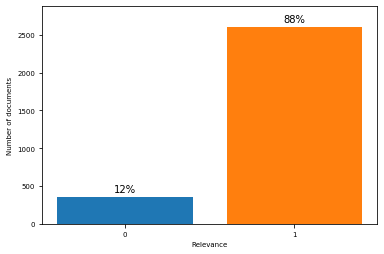

In [8]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams)

In [11]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=20, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

ab_X = vec.fit_transform(df['content'])

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### We build 3 types of classifiers, and test these with k-fold cross validation

In [10]:
from sklearn.model_selection import KFold



models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


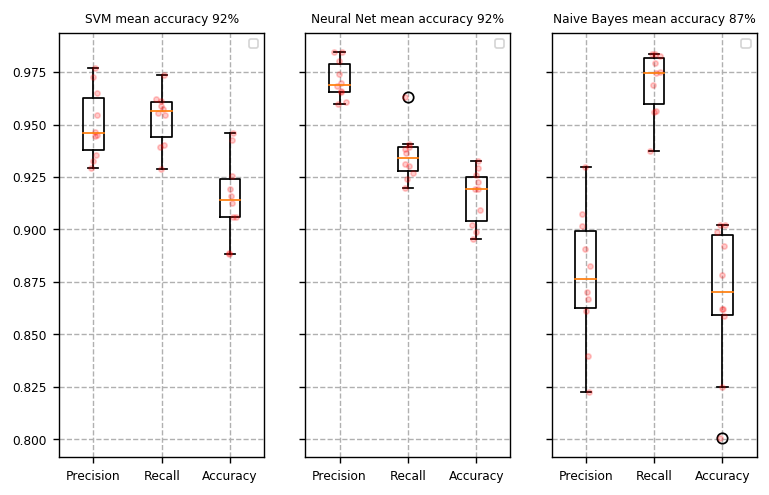

In [11]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        y = model[s]
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax.plot(x, y, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

### We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [ ]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [ ]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

plt.show()

### Now we make a new random sample

In [ ]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

In [ ]:
t1, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  

    
t1.update_tag()
            
t1.update_tag()

## Now we try and predict governance and policies

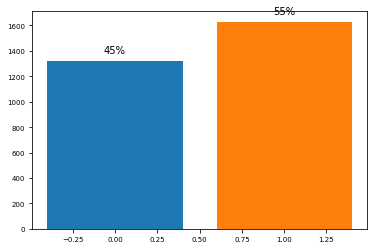

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(df[df['seen']==1].groupby('Governance & policies')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [13]:
from sklearn.model_selection import KFold

y = df['Governance & policies']
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    print(i)
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

1
2
3
4
5
6
7
8
9
10


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


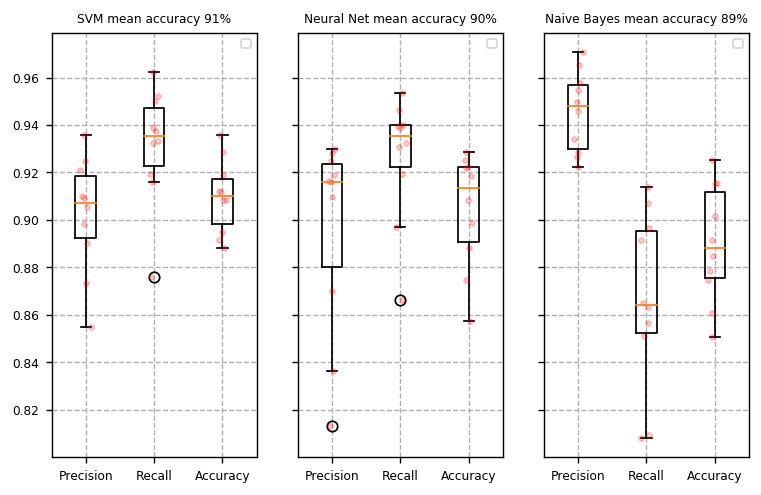

In [14]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        ys = model[s]
        x = np.random.normal(i+1, 0.04, size=len(ys))
        ax.plot(x, ys, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [15]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"doctables/models_governance_policies_fpfn_{now}.csv",index=False)

In [16]:
kf = KFold(n_splits=10)
i=0
all_mistakes = None
df['mispredicted'] = 0


all_fps = None
all_fns = None

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)
    clf.fit(ab_X[k_train],y[k_train])
    
    y_pred = clf.predict_proba(ab_X[k_test])
    
    fns = np.argwhere((np.array(y[k_test])>0.5) & (y_pred[:,1] < 0.5))
    fps = np.argwhere((np.array(y[k_test])<0.5) & (y_pred[:,1] > 0.5))
    
    print(f"mean prediction for false +ves {y_pred[fps,1].mean()}")
    print(f"mean prediction for false -ves {y_pred[fns,1].mean()}")
    
    mistakes = np.append(fps,fns)
    
    df.loc[k_test[mistakes],'mispredicted'] = 1
    
    if all_fps is not None:
        all_fps = np.append(all_fps,y_pred[fps,1][:,0])
    else:
        all_fps = y_pred[fps,1][:,0]
    if all_fns is not None:
        all_fns = np.append(all_fns,y_pred[fns,1][:,0])
    else:
        all_fns = y_pred[fns,1][:,0]    
    


mean prediction for false +ves 0.7406530615483223
mean prediction for false -ves 0.23873426734541822
mean prediction for false +ves 0.7349397344196991
mean prediction for false -ves 0.20547537956813075
mean prediction for false +ves 0.73721312705106
mean prediction for false -ves 0.22539233611390036
mean prediction for false +ves 0.8098991942075341
mean prediction for false -ves 0.2840659333367918
mean prediction for false +ves 0.7998974288190247
mean prediction for false -ves 0.2792941225357591
mean prediction for false +ves 0.7560970521041206
mean prediction for false -ves 0.29494768210705086
mean prediction for false +ves 0.6696416181517719
mean prediction for false -ves 0.27309711544021664
mean prediction for false +ves 0.6953979429652464
mean prediction for false -ves 0.2845405229678848
mean prediction for false +ves 0.6821300828186604
mean prediction for false -ves 0.26857506333598136
mean prediction for false +ves 0.7189137354637278
mean prediction for false -ves 0.2579961496323

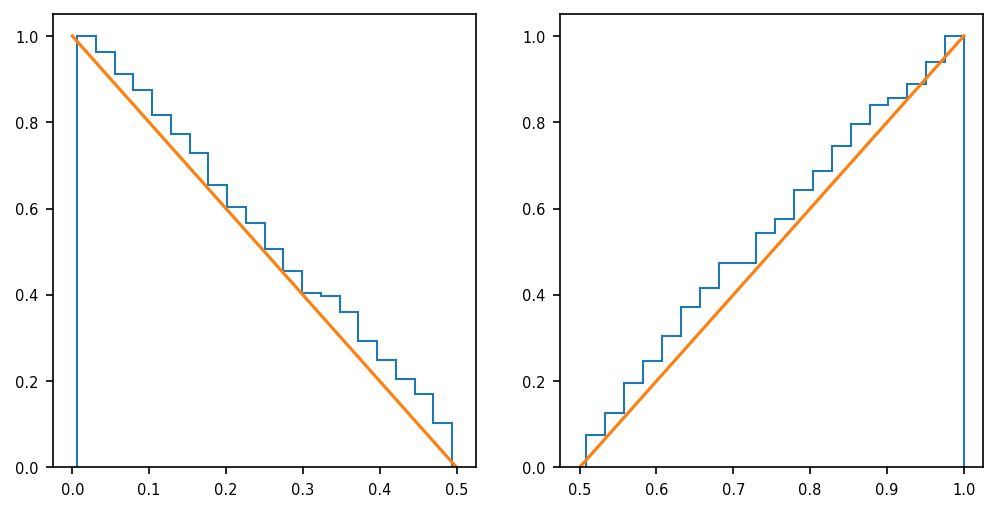

In [17]:
fig, axs = plt.subplots(1,2,figsize=(8, 4), dpi=150)
n, bins, patches = axs[1].hist(all_fps, 20, density=True, histtype='step',
                       cumulative=True, label='Empirical')

axs[1].plot([0.5,1],[0,1])

n, bins, patches = axs[0].hist(all_fns, 20, density=True, histtype='step',
                   cumulative=-1, label='Empirical')
axs[0].plot([0,0.5],[1,0])

plt.show()

In [67]:
t1 = Tag(
    title="Governance & policies false positives and negatives {}".format(now),
    query=q
)
t1.save()
for i, row in df.query('mispredicted==1').iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(t1)
t1.update_tag()

<module 'django.db.models' from '/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/django/db/models/__init__.py'>

In [18]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

26917
91944


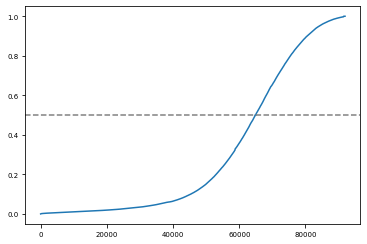

In [19]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

### Now we can make a new tag and screening decision objects with the x documents most likely to be relevant

In [20]:
q = Query.objects.get(pk=qid)
q.users.all()

<QuerySet [<User: maowenxin2014@163.com>]>

In [21]:
import datetime


t1 = Tag(
    title="predicted policy sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  

    
t1.update_tag()


In [22]:
df[['id','prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)

## Now we want to look at mitigation and adaptation

In [134]:
df['mit/ad'] = df['Mitigation'] + df['Adaptation']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'Adaptation'].sum())
print("seen mitigation and adaptation documents", df.loc[df['mit/ad']==2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0])

seen documents: 2968
seen mitigation documents: 2028.0
seen adaptation documents 847.0
seen mitigation and adaptation documents 267
seen non-mit/ad documents 360


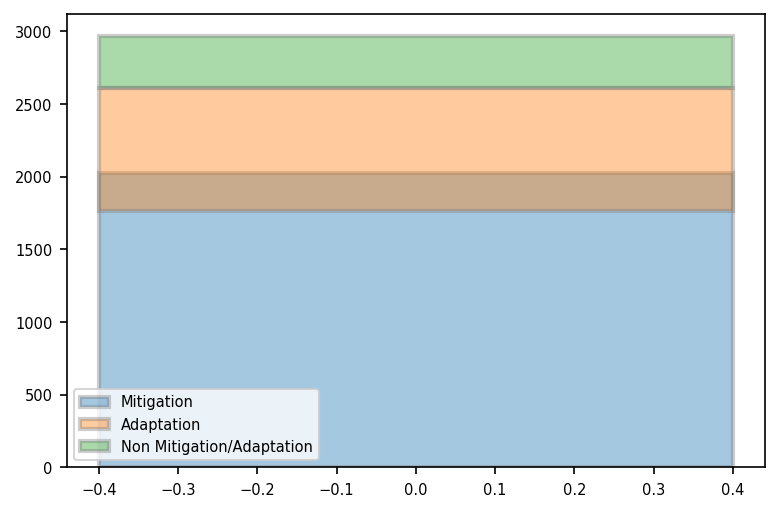

In [219]:
fig, ax = plt.subplots(dpi=150)

mitigation = df.loc[df['seen']==1,'Mitigation'].sum()
adaptation = df.loc[df['seen']==1,'Adaptation'].sum()
overlap = df.loc[df['mit/ad']==2,].shape[0]
nonmitad = df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0]

lw = 2
alpha=0.4
ec = "grey"

ax.bar(
    0,mitigation,
    alpha=alpha, label="Mitigation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,adaptation,bottom=mitigation-overlap,
    alpha=alpha, label="Adaptation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonmitad,bottom=mitigation-overlap+adaptation,
    alpha=alpha, label="Non Mitigation/Adaptation",
    lw=lw, edgecolor=ec
)

ax.legend()

In [150]:
classes = ["Mitigation","Adaptation"]
y = np.matrix(df[classes])
y.shape

(94912, 2)

In [237]:
from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

for model in multimodels:
    model['e'] = []
    model['i'] = []
    metrics = ['e','p\nboth','r\nboth']
    model['p\nboth'] = []
    model['r\nboth'] = []
    for j, y_class in enumerate(classes):
        model[f'p\n{y_class}'] = []
        model[f'r\n{y_class}'] = []
        metrics += [f'p\n{y_class}', f'r\n{y_class}']

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    print(i)
    for model in multimodels:
        clf = model['model']
        model['i'].append(i)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        both = y[k_test].sum(axis=1)//2
        both_predictions = predictions.sum(axis=1)//2
        model[f'p\nboth'].append(precision_score(both_predictions, both))
        model[f'r\nboth'].append(recall_score(both_predictions, both))
        for j, y_class in enumerate(classes):
            model[f'p\n{y_class}'].append(precision_score(predictions[:,j],y[k_test,j]))
            model[f'r\n{y_class}'].append(recall_score(predictions[:,j],y[k_test,j]))


1
2
3
4
5
6
7
8
9
10


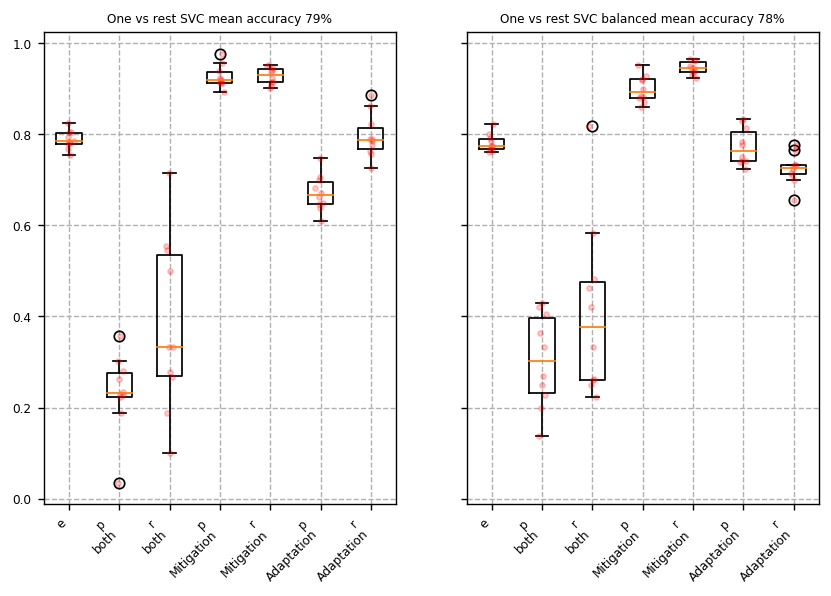

In [242]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,len(multimodels),dpi=125,figsize=(8,5),sharey=True)
for i, model in enumerate(multimodels):
    ax = axs[i]
    ax.boxplot([model[x] for x in metrics])
    
    for i,s in enumerate(metrics):
        ys = model[s]
        x = np.random.normal(i+1, 0.04, size=len(ys))
        ax.plot(x, ys, 'r.', alpha=0.2)
    
    ax.set_xticklabels([x for x in metrics], rotation=45, ha="right")
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    
plt.show()

In [236]:
metrics = ['e','p\nboth','r\nboth']
for j, y_class in enumerate(classes):
    metrics += [f'p\n{y_class}', f'r\n{y_class}']
    
metrics

['e',
 'p\nboth',
 'r\nboth',
 'p\nMitigation',
 'r\nMitigation',
 'p\nAdaptation',
 'r\nAdaptation']